# 🧠 Image Classification with CNN – Animals10 Dataset

This project implements a Convolutional Neural Network (CNN) from scratch using TensorFlow/Keras to classify 10 animal categories. It includes preprocessing, training, evaluation, and holdout set predictions.


## 📦 1. Setup and Imports

In [6]:
import os
import zipfile
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Import load_img and img_to_array from tensorflow.keras.utils
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

## 📁 2. Mount Drive and Extract Data

In [11]:
def mount_and_extract(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(extract_to))
        print(f"✅ Extracted: {os.path.basename(zip_path)}")

drive.mount('/content/drive')

mount_and_extract("/content/drive/MyDrive/IronHack/animals10.zip", "/content/animals10/raw-img")
mount_and_extract("/content/drive/MyDrive/IronHack/holdout.zip", "/content/animals10/holdout/raw-img")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted: animals10.zip
✅ Extracted: holdout.zip


## 🧼 3. Preprocessing with ImageDataGenerator

In [17]:
def prepare_data_generators(base_path, img_size=(128, 128), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    # Point flow_from_directory to the directory containing the class subdirectories
    train = datagen.flow_from_directory(base_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='training')
    val = datagen.flow_from_directory(base_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='validation')
    return train, val

# Change the base_path to the directory containing 'raw-img' and then the class folders
train_gen, val_gen = prepare_data_generators("/content/animals10/animals10/raw-img")

Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.


## 🖼️ 4. Preview Sample Images

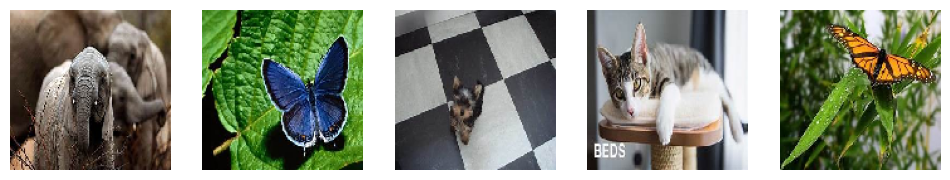

In [18]:
def preview_images(generator):
    imgs, _ = next(generator)
    plt.figure(figsize=(12, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.show()

preview_images(train_gen)

## 🏗️ 5. Define and Compile CNN Model

In [19]:
def create_cnn_model(input_shape=(128, 128, 3), num_classes=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 🚂 6. Train the Model

In [20]:
history = model.fit(train_gen, validation_data=val_gen, epochs=15)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - accuracy: 0.2537 - loss: 2.0865 - val_accuracy: 0.4181 - val_loss: 1.6394
Epoch 2/15
590/590 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.4190 - loss: 1.6664 - val_accuracy: 0.5041 - val_loss: 1.4430
Epoch 3/15
590/590 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.4881 - loss: 1.4630 - val_accuracy: 0.5876 - val_loss: 1.2086
Epoch 4/15
590/590 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.5581 - loss: 1.2754 - val_accuracy: 0.6135 - val_loss: 1.1224
Epoch 5/15
590/590 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.6201 - loss: 1.1015 - val_accuracy: 0.6483 - val_loss: 1.0656
Epoch 6/15
590/590 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.6627 - loss: 0.9850 - val_accuracy: 0.6628 - val_loss: 1.0142
Epoch 7/15
590/590 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.6961 - loss: 0.8721 - val_accuracy: 0.6647 - val_loss: 1.0526
Epoch 8/15
590/590 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.7420 - loss: 0.7551 - val_accurac

## 📊 7. Evaluate Performance

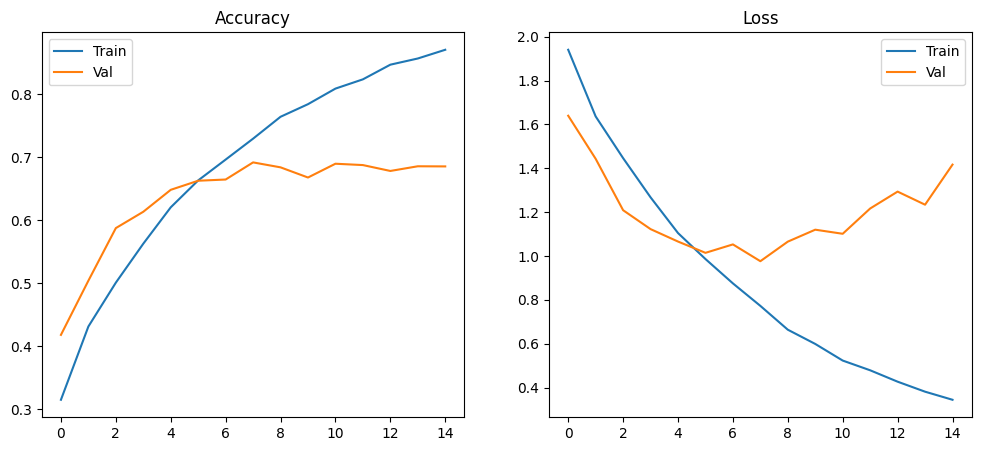

In [21]:
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_metrics(history)

## 📈 8. Classification Report & Confusion Matrix

              precision    recall  f1-score   support

   butterfly       0.06      0.05      0.06       380
         cat       0.07      0.05      0.06       300
     chicken       0.13      0.16      0.14       557
         cow       0.05      0.05      0.05       336
         dog       0.19      0.22      0.20       875
    elephant       0.04      0.03      0.03       260
       horse       0.08      0.09      0.09       472
       sheep       0.06      0.05      0.05       327
      spider       0.18      0.18      0.18       867
    squirrel       0.08      0.07      0.08       335

    accuracy                           0.12      4709
   macro avg       0.09      0.09      0.09      4709
weighted avg       0.12      0.12      0.12      4709



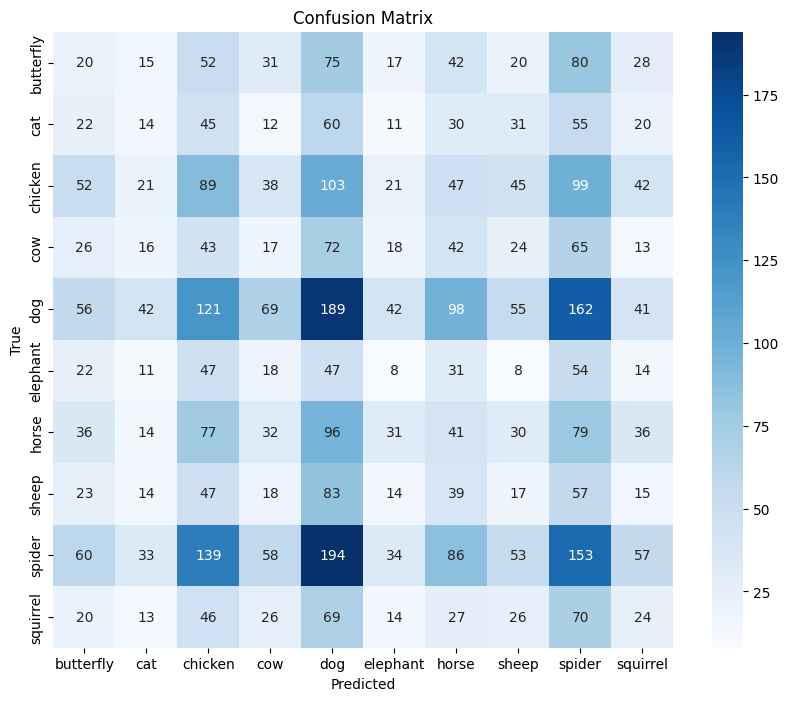

In [22]:
def evaluate_model(model, val_gen):
    y_true = val_gen.classes
    y_pred = np.argmax(model.predict(val_gen, verbose=0), axis=1)
    labels = list(val_gen.class_indices.keys())

    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, val_gen)

## 🔍 9. Predict on Holdout Set

In [24]:
def predict_holdout(model, holdout_path, class_labels):
    misclassified = []
    for class_name in os.listdir(holdout_path):
        folder = os.path.join(holdout_path, class_name)
        if not os.path.isdir(folder):
            continue
        for img_file in os.listdir(folder)[:5]:
            if not img_file.lower().endswith(('jpg', 'png', 'jpeg')):
                continue
            img_path = os.path.join(folder, img_file)
            # Use the imported load_img and img_to_array directly
            img = load_img(img_path, target_size=(128, 128))
            img_arr = img_to_array(img)
            img_arr = np.expand_dims(img_arr, axis=0) / 255.
            pred = model.predict(img_arr)
            pred_label = class_labels[np.argmax(pred)]
            if pred_label != class_name:
                misclassified.append((img_path, class_name, pred_label))

    return misclassified

misclassified = predict_holdout(model, "/content/animals10/holdout/raw-img", list(train_gen.class_indices.keys()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

## 🖼️ 10. Display Misclassified Holdout Samples

❌ Found 5 misclassified images.


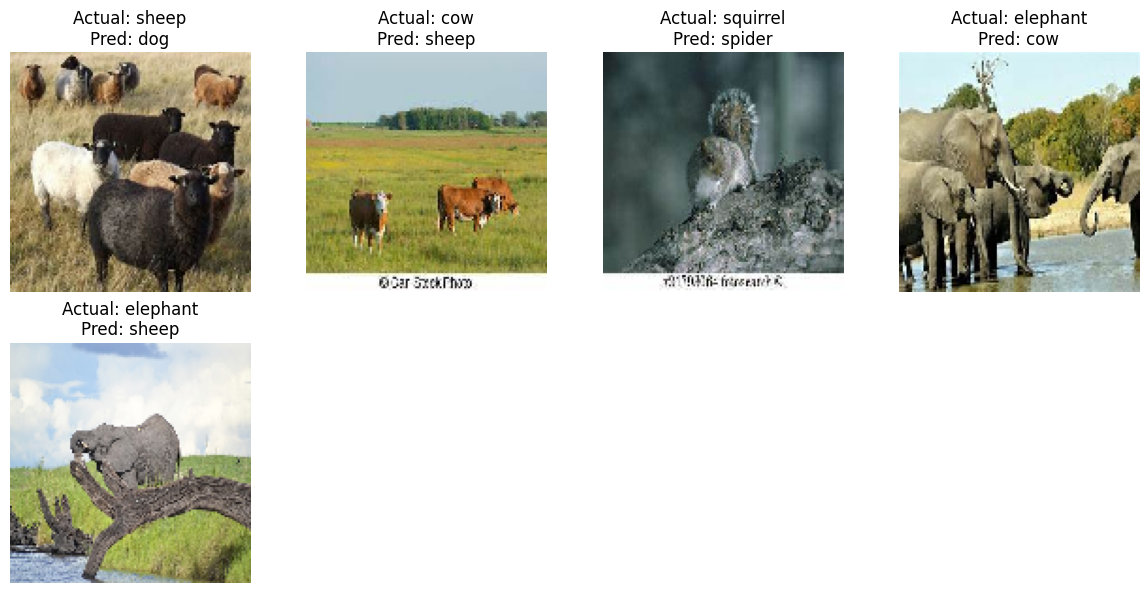

In [25]:
def display_misclassified(misclassified):
    if not misclassified:
        print("✅ No misclassifications in preview.")
        return
    print(f"❌ Found {len(misclassified)} misclassified images.")
    plt.figure(figsize=(12, 6))
    for i, (path, true_lbl, pred_lbl) in enumerate(misclassified[:8]):
        # Use the imported load_img directly
        img = load_img(path, target_size=(128, 128))
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"Actual: {true_lbl}\nPred: {pred_lbl}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_misclassified(misclassified)